In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import ray
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import pickle
%matplotlib inline

In [3]:
# Read AUDUSD data file
raw_data = pd.read_csv("/home/ujwal/Python Program/Exp-On-Supervised-ML-Algorithms/Regression/AUDUSD_Candlestick_1_Hour_BID_03.09.2007-01.10.2022.csv")
raw_data

,Gmt time,Open,High,Low,Close,Volume
0,03.09.2007 00:00:00.000,0.82127,0.82207,0.82057,0.82157,184.95
1,03.09.2007 01:00:00.000,0.82147,0.82287,0.82097,0.82237,310.37
2,03.09.2007 02:00:00.000,0.82227,0.82367,0.82187,0.82267,419.97
3,03.09.2007 03:00:00.000,0.82287,0.82387,0.82157,0.82327,367.18
4,03.09.2007 04:00:00.000,0.82337,0.82387,0.82127,0.82157,257.45
...,...,...,...,...,...,...
132187,01.10.2022 19:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132188,01.10.2022 20:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132189,01.10.2022 21:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132190,01.10.2022 22:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00


In [4]:
# drop everything except Time and Close information
from bleach import clean
from matplotlib.pyplot import plot


clean_data = raw_data.drop(["High", "Open", "Low", "Volume"], axis=1)
df = clean_data.set_index('Gmt time')
df
#plot()

,Close
Gmt time,
03.09.2007 00:00:00.000,0.82157
03.09.2007 01:00:00.000,0.82237
03.09.2007 02:00:00.000,0.82267
03.09.2007 03:00:00.000,0.82327
03.09.2007 04:00:00.000,0.82157
...,...
01.10.2022 19:00:00.000,0.64023
01.10.2022 20:00:00.000,0.64023
01.10.2022 21:00:00.000,0.64023


<AxesSubplot:xlabel='Gmt time'>

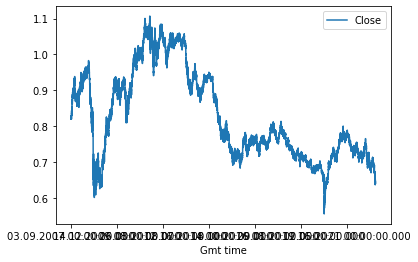

In [5]:
df.plot()

In [6]:
sum_inf = np.isinf(df).values.sum()
sum_nan = df.isna().sum()
print("number of inf value present =", sum_inf)
print("number of nan value present =", sum_nan)

number of inf value present = 0
number of nan value present = Close    0
dtype: int64


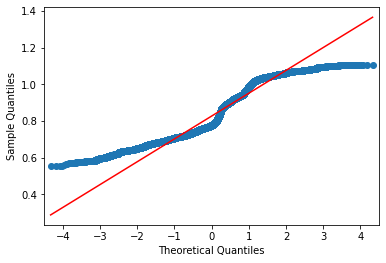

In [7]:
# qqplot shows the value not normally distributed
from statsmodels.graphics.gofplots import qqplot

# q-qplot
qqplot(df.Close, line= 's')
pyplot.show()

In [8]:
# visually data is non stationary
# Lets do Dickey-fuller test for conformation
# if P<0.05 && adf<-3.96 than data is stationary or it is not stationary
from statsmodels.tsa.stattools import adfuller
#adftest = adfuller(df1)
#print('pvalue of adfuller test is: ', adftest[1])

result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.2730410973784418
p-value: 0.6414140450092467
Critial Values:
   1%, -3.430399488625976
Critial Values:
   5%, -2.8615618732559716
Critial Values:
   10%, -2.566781642358542


<AxesSubplot:xlabel='Gmt time'>

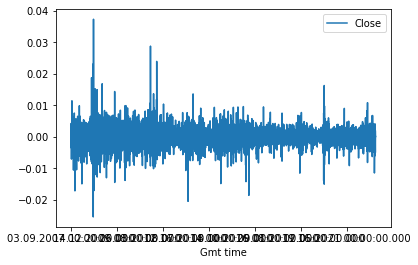

In [9]:
# Lets try differencing to remove trend
df1 = df.diff()
df1.plot()

In [10]:
sum_inf = np.isinf(df1).values.sum()
sum_nan = df1.isna().sum()
print("number of inf value present =", sum_inf)
print("number of nan value present =", sum_nan)

number of inf value present = 0
number of nan value present = Close    1
dtype: int64


In [11]:
df1 = df1.dropna()

In [12]:
#Lets re-test it again.
# Lets do Dickey-fuller test for conformation
# if P<0.05 && adf<-3.96 than data is stationary or it is not stationary
from statsmodels.tsa.stattools import adfuller
#adftest = adfuller(df1)
#print('pvalue of adfuller test is: ', adftest[1])

result = adfuller(df1, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -50.80346559599819
p-value: 0.0
Critial Values:
   1%, -3.430399488625976
Critial Values:
   5%, -2.8615618732559716
Critial Values:
   10%, -2.566781642358542


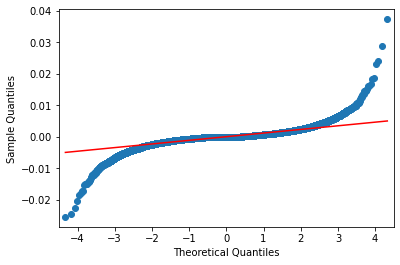

In [13]:
# qqplot shows the value not normally distributed
from statsmodels.graphics.gofplots import qqplot

# q-qplot
qqplot(df1.Close, line= 's')
pyplot.show()

In [16]:
print(len(df1))
print("train=",len(df1)*0.7)
print("val=", len(df1)*0.15)
print("test=", len(df1)*0.15)

132191
train= 92533.7
val= 19828.649999999998
test= 19828.649999999998


In [17]:
# Split dataset to train, val, test as 70%-15%-15%
train, series = df1[:92533], df1[92533:] 
print(len(train), len(series))
val, test = series[:19829], series[19829:]
print(len(train), len(val), len(test))

92533 39658
92533 19829 19829


<AxesSubplot:xlabel='Gmt time'>

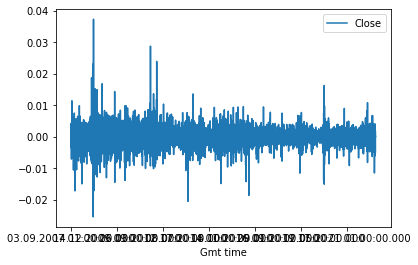

In [18]:

df1.plot()


In [19]:
import matplotlib.pyplot as plt

#plt.plot(train)
#plt.plot(val)
#plt.plot(test)
#plt.show()

In [20]:
import numpy as np

def sampling(sequence, n_steps):

    X, Y = list(), list()
    
    for i in range(len(sequence)):
        
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

n_steps = 30

train_X, train_Y = sampling(train['Close'].tolist(), n_steps)
val_X, val_Y = sampling(val['Close'].tolist(), n_steps)
test_X, test_Y = sampling(test['Close'].tolist(), n_steps)


In [21]:
# Initialize the algorithm
model = LinearRegression()

In [22]:
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['copy_X'] = [True, False]
space['positive'] = [True, False]
space['fit_intercept'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(val_X, val_Y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/ujwal/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=500. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: -0.0004141716152773328
Best Hyperparameters: {'positive': True, 'fit_intercept': False, 'copy_X': True}


In [23]:
# Train the algorithm
model = LinearRegression(fit_intercept=False, copy_X=True, positive=True)
model.fit(train_X,train_Y)

LinearRegression(fit_intercept=False, positive=True)

In [24]:
model.coef_

array([0.        , 0.00326795, 0.00135073, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00142092, 0.        ,
       0.00202623, 0.00374142, 0.00926359, 0.01293314, 0.        ,
       0.0057836 , 0.00582896, 0.        , 0.        , 0.        ,
       0.        , 0.01058105, 0.        , 0.0076268 , 0.        ,
       0.00307362, 0.00476424, 0.        , 0.        , 0.        ])

In [25]:
predictions = model.predict(test_X)

Text(0, 0.5, 'Predicted Y')

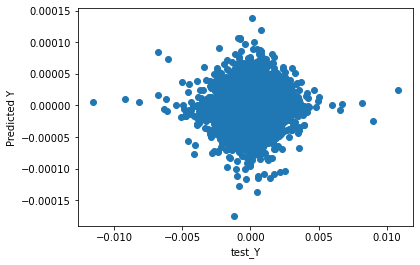

In [26]:
import matplotlib.pyplot as plt
plt.scatter(test_Y,predictions)
plt.xlabel('test_Y')
plt.ylabel('Predicted Y')

In [27]:
# Check mse using Linear regression
from sklearn import metrics
print('MAE :'," ", metrics.mean_absolute_error(test_Y,predictions))
print('MSE :'," ", metrics.mean_squared_error(test_Y,predictions))
print('RMAE :'," ", np.sqrt(metrics.mean_squared_error(test_Y,predictions)))

MAE :   0.0004843301126681979
MSE :   6.509614489757677e-07
RMAE :   0.000806821819843618


/home/ujwal/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

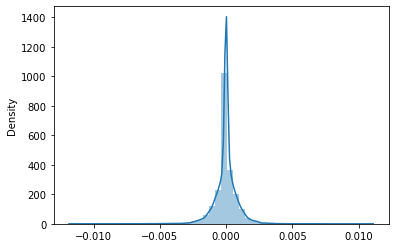

In [28]:
sns.distplot(test_Y - predictions,bins=50)

In [29]:
# save model using pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [30]:
# loading model
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [132]:
test1, non_usable= test[:50], test[50:]
print(len(non_usable), len(test1))

19779 50


In [140]:
import numpy as np

def sampling(sequence, n_steps):

    X, Y = list(), list()
    
    for i in range(len(sequence)):
        
        sam = i + n_steps
        yam = i + 11
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[(i+1):yam]
        print(y)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

n_steps = 30


test_x, test_y = sampling(test1['Close'].tolist(), n_steps)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0014899999999999913]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0014899999999999913, 0.0008900000000000574]
[0.0, 0.0, 0.0, 0.0, 0.0, 

In [134]:
# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

import sys
np.set_printoptions(threshold=sys.maxsize)

In [141]:

#A_NEW = A[start_index_row : stop_index_row, start_index_column : stop_index_column)]
test_x[1:3,:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [136]:
test_y[0:1,:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [142]:
len(test_x)

20

In [138]:
# demonstrate prediction for next 10 days
prediction = []
for i in range(len(test_x)):
    x_input = test_x[i:(i+1),:20]
    temp_input=list(x_input)
    n_features = 1
    lst_output=[]
    n_steps = 20
    i=0
    while(i<10):
        
        if(len(temp_input)>3):
            x_input=array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            #print(x_input)
            x_input = x_input.reshape((1, n_steps, n_features))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.append(yhat[0][0])
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.append(yhat[0][0])
            i=i+1
        #else:
            #x_input = x_input.reshape(1, n_steps)
            #yhat = model.predict(x_input)
            #print(yhat[0])
            #temp_input.append(yhat[0][0])
            #lst_output.append(yhat[0][0])
            #i=i+1
        
    prediction.append(lst_output)
    print(lst_output)

KeyboardInterrupt: 

In [143]:
# demonstrate prediction for next 10 days

x_input = test_x[:1,:20]
temp_input=list(x_input)
n_features = 1
lst_output=[]
n_steps = 20
i=0
while(i<10):
    
    if(len(temp_input)>3):
        x_input=array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    #else:
        #x_input = x_input.reshape(1, n_steps)
        #yhat = model.predict(x_input)
        #print(yhat[0])
        #temp_input.append(yhat[0][0])
        #lst_output.append(yhat[0][0])
        #i=i+1

print(lst_output)

KeyboardInterrupt: 

In [183]:
x_input = test_x[:1,:20]
x_input = x_input.reshape(-1,1)
x_input

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [178]:
# demonstrate prediction for next 10 days
#temp_input=list(x_input)
lst_output=[]
n_features = 1
n_steps = 10
i=0
while(i<10):
    
    if(len(temp_input)>0):
        #x_input=temp_input[1:]
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = np.array(x_input)
        x_input = x_input.reshape(-1,1)
        #print(x_input)
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = np.array(x_input)
        x_input = x_input.reshape(-1,1)
        yhat = model.predict(x_input)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
# Check mse using Linear regression
from sklearn import metrics
print('MAE :'," ", metrics.mean_absolute_error(test_y,prediction))
print('MSE :'," ", metrics.mean_squared_error(test_y,prediction))
print('RMAE :'," ", np.sqrt(metrics.mean_squared_error(test_y,prediction)))

NameError: name 'test_X' is not defined

In [ ]:
import fxtm
import datetime as dt